# Groundwater level data exploration

The aim here is to explore the raw data of the groundwater levels in the Lower Saxony State in Germany. 

In [153]:
#Import libraries
%matplotlib notebook
import matplotlib.dates as mdates
import matplotlib.transforms as transforms
from functions import *
import warnings
import contextily as cx
import matplotlib.colors as mcolors
from IPython.display import Markdown as md

In [2]:
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
rpath="D:/Data/students/mariana/data/" #Root path

## Selection criteria
There is a pre-selection of well stations based on the "climatic hydrograph" method (agreement between the theoretical and observed hydrograph) and a proposal list from previous projects (KIT-BGR). The assessment contains subjective components, based on past analyses. This selection exclude wells under strong anthropogenic incluences such as pumping, allowing to assure a dependencz between the climatic input variables and the groundwater data.

In [4]:
#Import Groundwatwer stations
GW_CD_ID= gpd.read_file(rpath+"SHP/GWL_CDID.shp")
GW_CD_sel=GW_CD_ID[GW_CD_ID.KLIGL_GRUP.isin([1,12,13])] # selection of stations in good agreement with climatic variables


In [5]:
total_wells= GW_CD_ID.shape[0]
sel_wells= GW_CD_sel.shape[0]
md(f"The data consists of a total of {total_wells} wells. \
   <br> After excluding the wells under anthropogenic influence:  {sel_wells} wells.")

The data consists of a total of 962 wells.    <br> After excluding the wells under anthropogenic influence:  745 wells.

### Load groundwater level data according to criteria

In [6]:
gwlist=[]
gidlist=[]
for gid in GW_CD_sel.MEST_ID : # Load data from selected IDs
    gw=readGWdata(gid,rpath +"/Grundwasserstandsdaten/Einzelmessstellen/")
    gwlist.append(gw)
    gidlist.append(gid)
    nonan=gw.GW_NN.count()
    index=GW_CD_sel.loc[GW_CD_sel.MEST_ID==gid].index.values[0]
    GW_CD_sel.loc[index, "nonan"]=nonan
gwdata_dic={"wellid":gidlist, "data":gwlist}

#Dataframe containing all the well information available
gwdata=pd.DataFrame(gwdata_dic)

##Save groundwater data
#gwdata.to_pickle(rpath+"/data/Pickle/gwdata.pkl") 

##  Time range

This is used as a spatial overview of the data length

In [7]:
#Load groudnwater data
gwdata= pd.read_pickle(rpath+"Pickle/gwdata.pkl")

#Convert monthly measurements to annual assuming no gaps to check the time series length
#GW_CD_sel["nonan_yr"]=GW_CD_sel["nonan"]/12

In [8]:
gwdata.data[0]

,MEST_ID,JAHR,MONAT,DATUM,HJAHR,HMONAT,GW_NN,FLURABST,MW_ABST
0,9610009,1950,1,1950-01-15,1950,3,NaN,NaN,NaN
1,9610009,1950,2,1950-02-15,1950,4,NaN,NaN,NaN
2,9610009,1950,3,1950-03-15,1950,5,NaN,NaN,NaN
3,9610009,1950,4,1950-04-15,1950,6,NaN,NaN,NaN
4,9610009,1950,5,1950-05-15,1950,7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
859,9610009,2021,8,2021-08-15,2021,10,0.43,0.76,1.41
860,9610009,2021,9,2021-09-15,2021,11,NaN,NaN,NaN
861,9610009,2021,10,2021-10-15,2021,12,NaN,NaN,NaN
862,9610009,2021,11,2021-11-15,2022,1,NaN,NaN,NaN


<IPython.core.display.Javascript object>


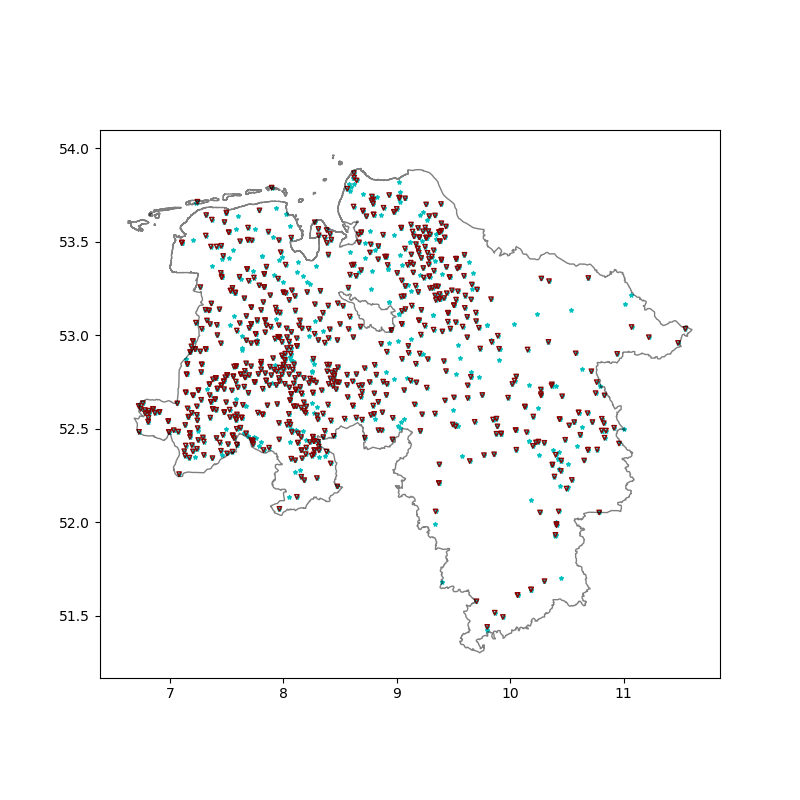

<AxesSubplot:>

In [10]:
#Plot GW stations with data information
germany_states = gpd.read_file(rpath+"/SHP/DEU_adm1.shp")
NS=germany_states[germany_states.NAME_1== "Niedersachsen"]
GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
GW_CD_sel=GW_CD_sel.to_crs(epsg=4326)
NSmap= NS.boundary.plot( figsize=(8, 8), alpha=0.5, edgecolor='k', linewidth=1)
GW_CD_ID.plot(ax=NSmap,marker='*', color='c', markersize=8, label="GW")
GW_CD_sel.plot(ax=NSmap,markersize=10, marker="v", facecolor="None",legend=True, color="darkred", label="GW_sel")



## Gaps length

Check the gap lengths to define the interpolation method

In [13]:
#Load groundwater saved data
gwdata= pd.read_pickle(rpath+"Pickle/gwdata.pkl")

gaps_list=[]
count=[]
for i in range(sel_wells):
    gwdatam=gwdata.data[i].dropna(subset='GW_NN', inplace=False)#Drop nan values 
    deltas=gwdatam["DATUM"].diff()[1:]
    gaps = deltas[deltas > dt.timedelta(days=31)]
    gaps_list.append(gaps)
    count.append(len(gaps))
    
gwdata["count"]=count
gwdata["gaps"]=gaps_list
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)

In [14]:
#Estimate gap interval in days and months - 2 months means 1 missing data
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)
gwdata["max_gap_months"]=gwdata.gaps.apply(lambda x: x.max().days/30)

In [91]:
gwdata['max_gap'] = gwdata['max_gap'].replace(np.nan, 0)
gwdata['max_gap_months'] = gwdata['max_gap_months'].replace(np.nan, 0)

In [93]:
gwdatasort0=gwdata.copy()
gwdatasort=gwdatasort0.sort_values(by="max_gap", ascending=False).reset_index(drop=True)

In [94]:
gwdatasort.max_gap_months.loc[gwdatasort.max_gap_months.isnull()]=0

<IPython.core.display.Javascript object>


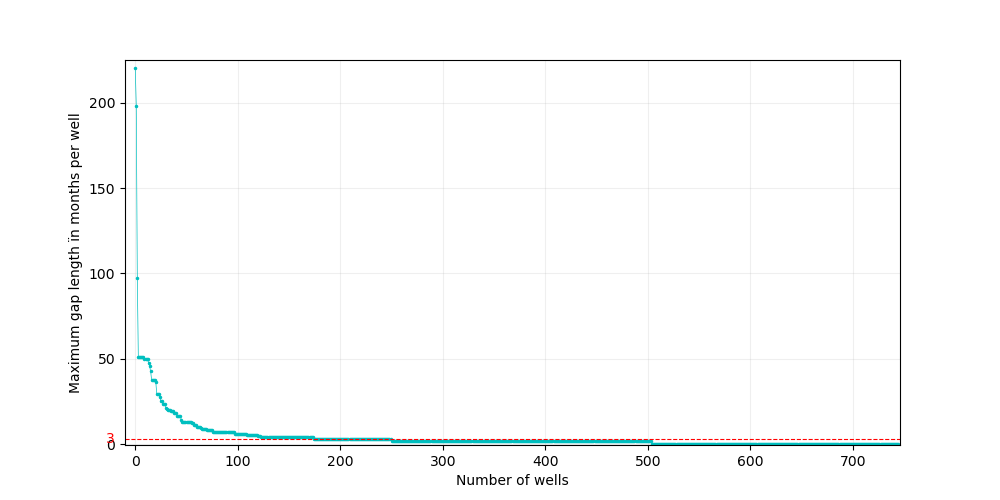

In [110]:
#Plot the maximum gap (in months) 
thresh=3 #Maximum number of gap length allowed
fig, ax = plt.subplots(figsize=(10,5))
data=gwdata.sort_values(by="max_gap_months")
plt.plot(gwdatasort.index, gwdatasort["max_gap_months"], marker='.', markersize=3, color="c", lw=0.5)
ax.set_ylabel("Maximum gap length ïn months per well")
ax.set_xlabel("Number of wells")
ax.set_ylim(-0.5,int(gwdatasort["max_gap_months"].max())+5)
ax.set_xlim(-10,len(gwdatasort)+1)
plt.axhline(y=thresh, color="r", linestyle="--", lw="0.8", xmin=0, xmax=len(gwdatasort))

trans= transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
plt.text(0,thresh,"{:.0f}".format(thresh), color="r", transform=trans, ha="right", va="center")

plt.grid(True, alpha=0.2)

<IPython.core.display.Javascript object>


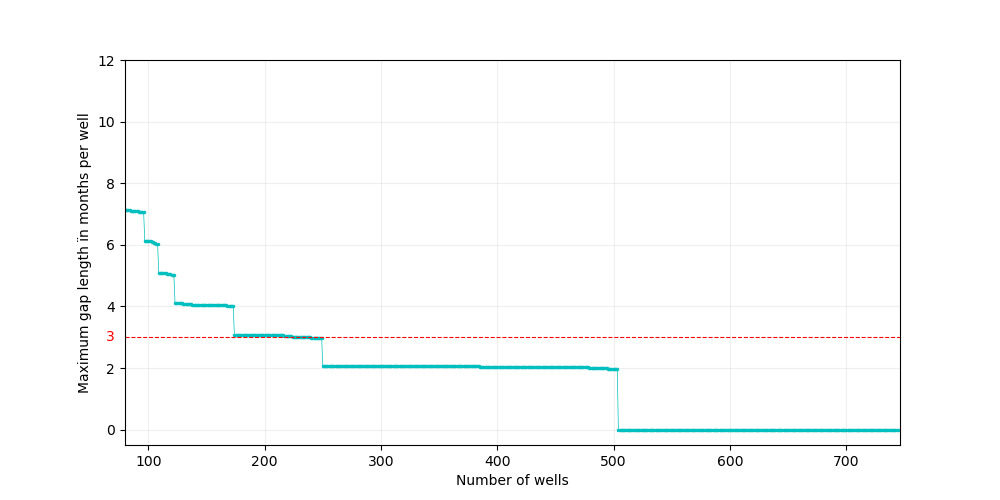

In [112]:
#CLOSER VIEW
thresh=3 #Maximum number of gap length allowed
fig, ax = plt.subplots(figsize=(10,5))
data=gwdata.sort_values(by="max_gap_months")
plt.plot(gwdatasort.index, gwdatasort["max_gap_months"], marker='.', markersize=3, color="c", lw=0.5)
ax.set_ylabel("Maximum gap length ïn months per well")
ax.set_xlabel("Number of wells")
ax.set_ylim(-0.5,12)
ax.set_xlim(80,len(gwdatasort)+1)
plt.axhline(y=thresh, color="r", linestyle="--", lw="0.8", xmin=0, xmax=len(gwdatasort))

trans= transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
plt.text(0,thresh,"{:.0f}".format(thresh), color="r", transform=trans, ha="right", va="center")

plt.grid(True, alpha=0.2)

In [114]:
#Descriptive statistics
gwdata.max_gap_months.describe()

count    745.000000
mean       4.621834
std       13.691166
min        0.000000
25%        0.000000
50%        2.066667
75%        3.066667
max      220.200000
Name: max_gap_months, dtype: float64

<IPython.core.display.Javascript object>


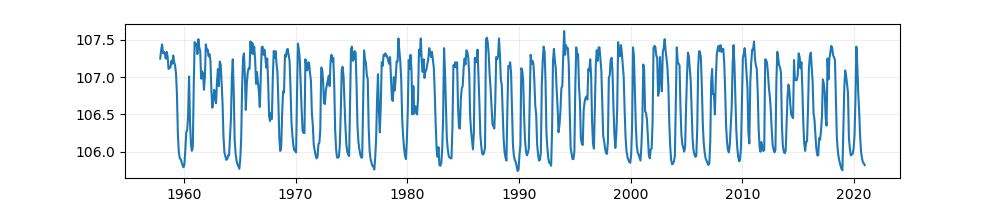

In [115]:
gwwell=gwdata.data[35]
Fig= plt.figure(figsize=(10,2))
plt.plot(gwwell["DATUM"], gwwell["GW_NN"])
plt.grid(True, alpha=0.2)

### Filter data with gaps longer than 4 months

In [106]:
gw_gapsel=gwdata[gwdata["max_gap"]<30*3]
gw_gapsel.shape
#Save selected gw data
gw_gapsel.to_pickle(rpath+"/Pickle/gwsel.pkl") 

In [107]:
gw_gapsel

,wellid,data,count,gaps,max_gap,max_gap_months
0,9610009,MEST_ID JAHR MONAT DATUM HJAHR H...,8,761 61 days 763 61 days 766 61 days 776 ...,62.0,2.066667
2,9610749,MEST_ID JAHR MONAT DATUM HJAHR H...,3,763 61 days 776 62 days 799 61 days Name...,62.0,2.066667
3,9610863,MEST_ID JAHR MONAT DATUM HJAHR H...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
5,9610875,MEST_ID JAHR MONAT DATUM HJAHR H...,5,758 59 days 763 61 days 788 62 days 790 ...,62.0,2.066667
7,9610901,MEST_ID JAHR MONAT DATUM HJAHR H...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
...,...,...,...,...,...,...
715,40502600,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
716,100000609,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
718,100003869,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
732,9700203,MEST_ID JAHR MONAT DATUM HJAHR H...,2,"349 62 days 814 61 days Name: DATUM, dtype...",62.0,2.066667


In [117]:
GW_gapsel=GW_CD_sel[GW_CD_sel["MEST_ID"].isin(gw_gapsel["wellid"])]
GW_gapsel.shape
##Save grounwater stations filtered by gaps
GW_gapsel.to_file(rpath+"/SHP/GWF2.shp")

### Plot data availability

In [118]:
#Sort stations by latitude
gwgpd=GW_CD_sel.sort_values(by="UTM_Y").reset_index() 
gw_gapsel


,wellid,data,count,gaps,max_gap,max_gap_months
0,9610009,MEST_ID JAHR MONAT DATUM HJAHR H...,8,761 61 days 763 61 days 766 61 days 776 ...,62.0,2.066667
2,9610749,MEST_ID JAHR MONAT DATUM HJAHR H...,3,763 61 days 776 62 days 799 61 days Name...,62.0,2.066667
3,9610863,MEST_ID JAHR MONAT DATUM HJAHR H...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
5,9610875,MEST_ID JAHR MONAT DATUM HJAHR H...,5,758 59 days 763 61 days 788 62 days 790 ...,62.0,2.066667
7,9610901,MEST_ID JAHR MONAT DATUM HJAHR H...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
...,...,...,...,...,...,...
715,40502600,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
716,100000609,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
718,100003869,MEST_ID JAHR MONAT DATUM HJAHR ...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",0.0,0.000000
732,9700203,MEST_ID JAHR MONAT DATUM HJAHR H...,2,"349 62 days 814 61 days Name: DATUM, dtype...",62.0,2.066667


In [119]:
#set dataframes to check the start and end of the well observation
c=0
df0=[]
df1=[]
for idv in gwgpd.MEST_ID:
    datawell=gw_gapsel.loc[gw_gapsel.wellid==idv].reset_index()
    if not datawell.empty:
        datwell= datawell.iloc[0].data
        data0=datwell.copy()
        data0.GW_NN.loc[~data0.GW_NN.isnull()]=c
        data1=datwell.copy()
        data1.GW_NN=c

        df0.append(data0)
        df1.append(data1)

        c+=1

In [120]:
li=[]
lf=[]
for df in df0:
    ivalid=df.GW_NN.first_valid_index()
    fvalid=df.GW_NN.last_valid_index()
    yri=df.DATUM[ivalid].year
    yrf=df.DATUM[fvalid].year
    li.append(yri)
    lf.append(yrf)
print()

In [121]:
max(lf)

md(f"The groundwater observations are available from {min(li)} until {max(lf)}. \
   But in general, the time range is highly variable")

The groundwater observations are available from 1950 until 2021.    But in general, the time range is highly variable

<IPython.core.display.Javascript object>


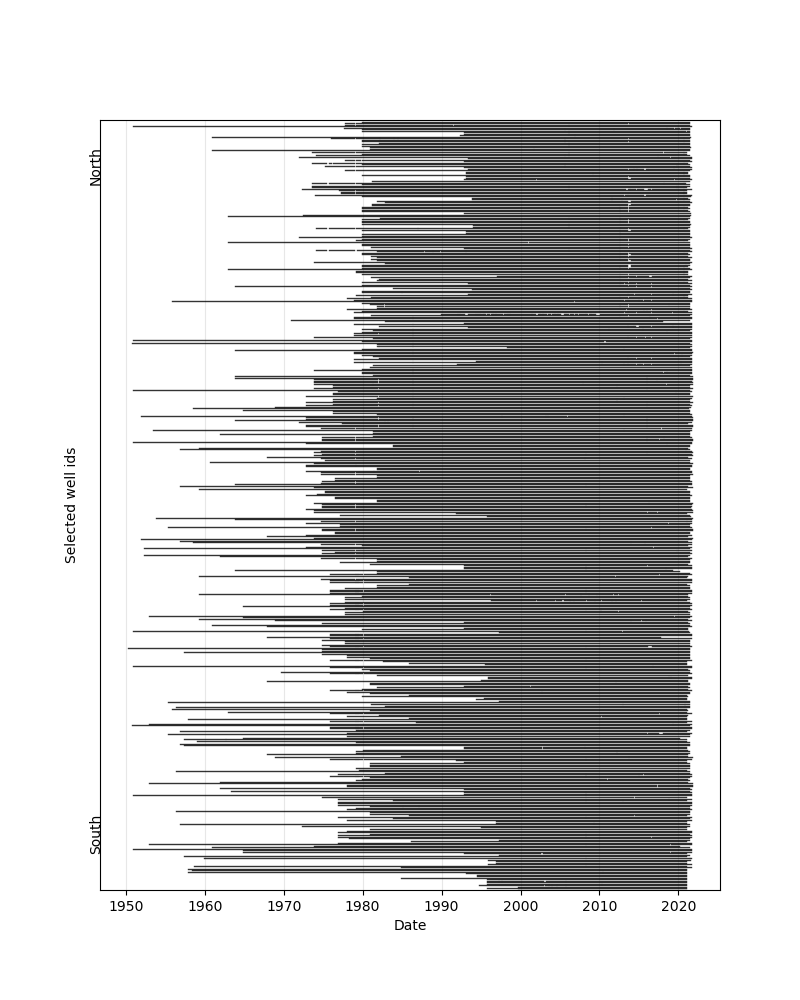

In [122]:
##Plot data availability after remove series with gap lenghts above 3 months. 

fig, ax = plt.subplots(figsize=(8,10))
for i in range(len(gw_gapsel)):
    #plt.plot(df1[i].DATUM,df1[i].GW_NN, c="r",lw=1)
    ax.plot(df0[i].DATUM,df0[i].GW_NN, c="k",lw=1, alpha=0.8)
ax.set_ylim(0,len(gw_gapsel))
ax.set_xlabel("Date")
ax.set_ylabel("Selected well ids", labelpad=15)
ax.grid(True, alpha=0.3, axis="x")
trans = ax.get_xaxis_transform() # x in data untis, y in axes fraction
ann = ax.annotate('North', xy=(-9020, 0.92), xycoords=trans, rotation=90)
ann2 = ax.annotate('South', xy=(-9020, 0.05), xycoords=trans, rotation=90)
ax.tick_params(axis='y',which='both',      
    left=False, labelleft=False, right=False) # labels along the bottom edge are off

<IPython.core.display.Javascript object>


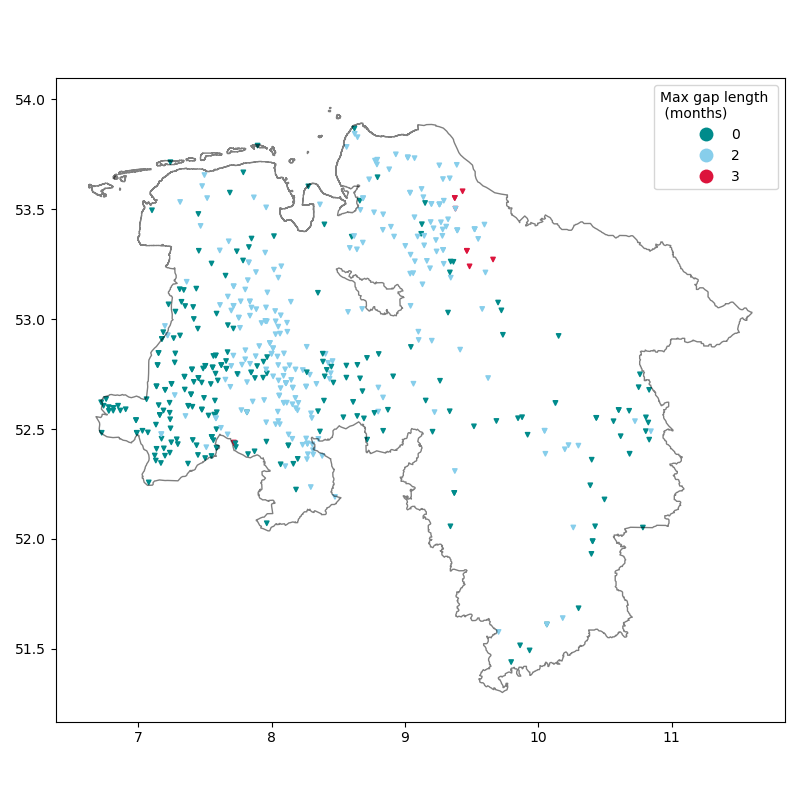

In [185]:
#Plot GW stations with data information
germany_states = gpd.read_file(rpath+"/SHP/DEU_adm1.shp")
GW_gapsel["max_gap"]=gw_gapsel.max_gap.values
GW_gapsel["max_gap_month"]=gw_gapsel.max_gap_months.values.round().astype(int)

NS=germany_states[germany_states.NAME_1== "Niedersachsen"]
GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
GW_gapsel=GW_gapsel.to_crs(epsg=4326)
pallete = {2: 'darkcyan', 0: 'skyblue', 3 : 'crimson'}
cmap = mcolors.ListedColormap([pallete[b] for b in GW_gapsel.max_gap_month.unique()])

gw=GW_gapsel.plot(figsize=(8, 8),column="max_gap_month",categorical=True, markersize=10,
               marker="v", facecolor="None",cmap=cmap, legend=True)
NS.boundary.plot( ax=gw, alpha=0.5, edgecolor='k', linewidth=1)

leg = gw.get_legend()
#legend = plt.legend( loc=4, fontsize='small', fancybox=True)
leg.set_title("Max gap length \n (months)")   

#cx.add_basemap(ax=NSmap, source=cx.providers.Stamen.TonerLabels)
#cx.add_basemap(ax=NSmap,  crs=GW_gapsel.crs.to_string(), zoom=10, source=cx.providers.Stamen.TonerLite)
plt.tight_layout()

In [191]:
GW_gapsel.loc[GW_gapsel["max_gap_month"]==3]

,MEST_ID,MS_LBEZ,MS_MSA_ID,UTM_X,UTM_Y,MS_EIG,MS_BTR,MS_GOKNN,MS_FOK,MS_FUK,...,BGR_REFERE,KLIGL_GRUP,AUSWAHL_KL,AUSWERTUNG,CD_ID_1,CD_ID_2,geometry,nonan,max_gap,max_gap_month
135,400080190,Wiepenkathen UE 19 FI,GWM,32528646.80,5937095.83,NLWKN,NLWKN Stade,4.30,25.0,27.0,...,N,1,Y,KLIMGL_30JAHRE_1987_2017,3853,1823.0,POINT (9.43270 53.58193),567.0,89.0,3
325,9700285,Wiechholzer Moor I,GWM,32412912.31,5810496.50,NLWKN,69,42.86,32.0,33.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,1628,714.0,POINT (7.71887 52.43772),523.0,89.0,3
326,9700286,Wiechholzer Moor II,GWM,32412912.31,5810497.50,NLWKN,69,42.91,55.0,56.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,1628,714.0,POINT (7.71887 52.43773),523.0,89.0,3
599,400060391,Klein-Meckelsen UE 39 FI,GWM,32530965.60,5906959.82,NLWKN,NLWKN Stade,36.25,18.0,20.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,3947,1820.0,POINT (9.46476 53.31092),506.0,89.0,3
628,400080381,Hamersen UE 38 FI,GWM,32532368.97,5899098.94,NLWKN,NLWKN Stade,33.47,15.0,17.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,3945,1820.0,POINT (9.48502 53.24018),506.0,89.0,3
656,405030392,Klein-Meckelsen UE 39 FII,GWM,32530963.60,5906956.82,NLWKN,NLWKN Stade,36.29,86.0,88.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,3947,1820.0,POINT (9.46473 53.31090),506.0,89.0,3
711,405180351,Wistedt-Tostedt UE 35 FI,GWM,32544084.34,5902671.41,NLWKN,NLWKN Stade,43.98,14.0,16.0,...,None,1,Y,KLIMGL_30JAHRE_1987_2017,4146,1920.0,POINT (9.66105 53.27145),471.0,89.0,3
822,400050083,Schwinge III,GWM,32524779.31,5933700.22,NLWKN,NLWKN Stade,22.25,50.0,64.0,...,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,3752,1723.0,POINT (9.37402 53.55161),337.0,89.0,3
826,400050162,Schwinge II,GWM,32524781.31,5933700.22,NLWKN,NLWKN Stade,22.26,30.0,44.0,...,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,3752,1723.0,POINT (9.37405 53.55161),338.0,89.0,3
827,400050182,Wedel II,GWM,32525147.11,5928269.38,NLWKN,NLWKN Stade,24.24,14.0,30.0,...,None,1,Y,KLIMGL_20JAHRE_1997_2017_208_128,3851,1722.0,POINT (9.37913 53.50278),327.0,89.0,3


<IPython.core.display.Javascript object>


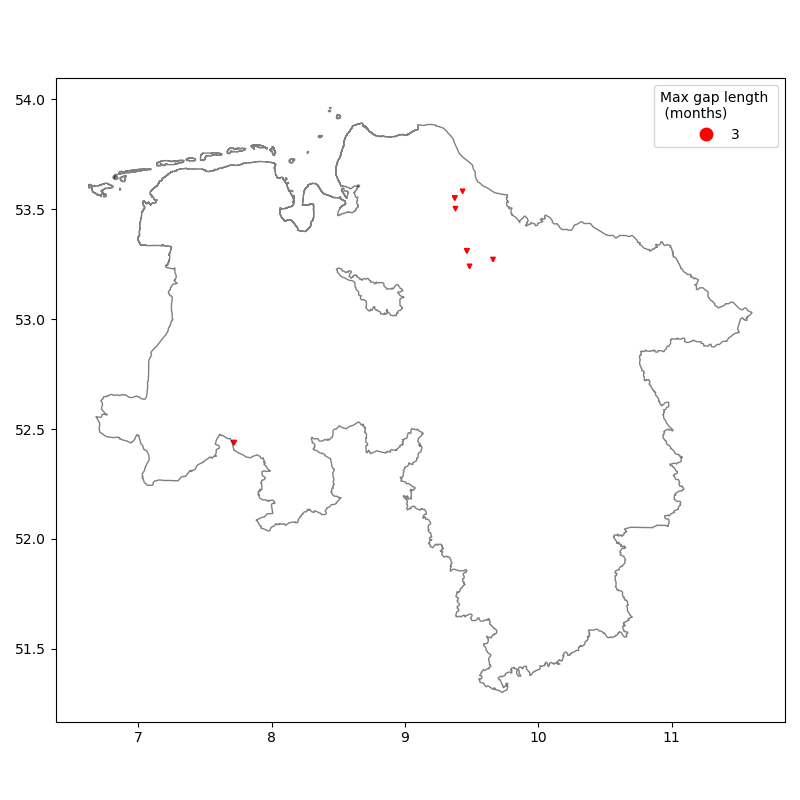

In [194]:
#Plot GW stations with data information

pallete = {2: 'red', 0: 'skyblue', 3 : 'crimson'}
cmap = mcolors.ListedColormap([pallete[b] for b in GW_gapsel.max_gap_month.unique()])

gw=g.plot(figsize=(8, 8),column="max_gap_month",categorical=True, markersize=10,
               marker="v", facecolor="None",cmap=cmap, legend=True)
NS.boundary.plot( ax=gw, alpha=0.5, edgecolor='k', linewidth=1)

leg = gw.get_legend()
#legend = plt.legend( loc=4, fontsize='small', fancybox=True)
leg.set_title("Max gap length \n (months)")   

#cx.add_basemap(ax=NSmap, source=cx.providers.Stamen.TonerLabels)
#cx.add_basemap(ax=NSmap,  crs=GW_gapsel.crs.to_string(), zoom=10, source=cx.providers.Stamen.TonerLite)
plt.tight_layout()